In [1]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from textblob import TextBlob

from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection
from sklearn.inspection import permutation_importance

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np
import matplotlib

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [3]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [4]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [5]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [6]:
df = get_samples(df,300000)

In [7]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [8]:
df.shape

(300000, 4)

In [9]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer
df['polarity'] = df['Q'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['Q'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

### In this part, I wanted to see how subjective or polar the questions are for each category

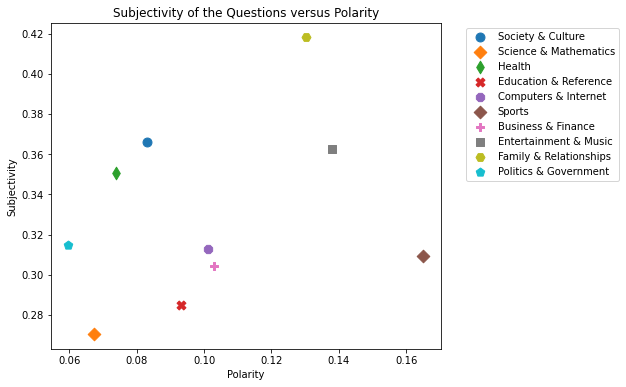

In [10]:
filled_markers = ('o', 'D', 'd', 'X','8', 'D','P','s','H', 'p')
fig,ax = plt.subplots(figsize=(7,6))
for i in range(1,11):
     ax.scatter(df[df.target==i]['polarity'].mean(),df[df.target==i]['subjectivity'].mean(),
                marker=filled_markers[i-1],label=target_classes[i-1],s=80,);

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');
ax.set_xlabel('Polarity');
ax.set_ylabel('Subjectivity');
ax.set_title('Subjectivity of the Questions versus Polarity');

### In this section, I'm interested to see how many of the following words have been used in the sentence
* what
* how
* I
* is
* why
* can
* do
* does
* where
* my

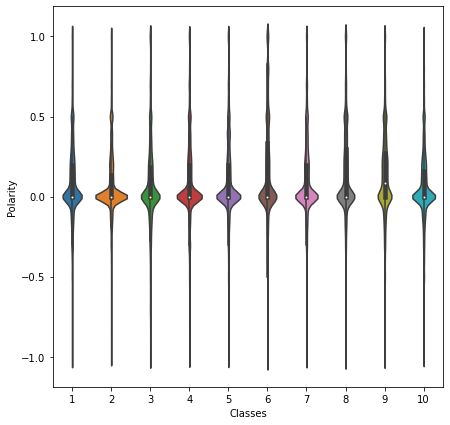

In [11]:
fig,ax=plt.subplots(figsize=(7,7));
ax = sns.violinplot(x='target',y='polarity', data=df , kind='swarm');
ax.set_xlabel('Classes');
ax.set_ylabel('Polarity');
matplotlib.rcParams.update({'font.size': 14})

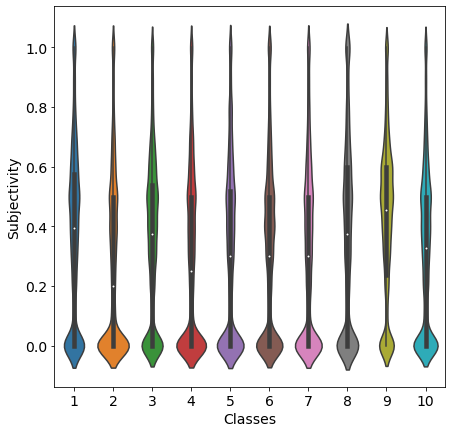

In [12]:
fig,ax=plt.subplots(figsize=(7,7));
ax = sns.violinplot(x='target',y='subjectivity', data=df , kind='swarm');
ax.set_xlabel('Classes');
ax.set_ylabel('Subjectivity');
matplotlib.rcParams.update({'font.size': 14})

In [13]:
df['what']= df['Q'].apply(lambda x:len(re.findall('what',str(x).lower())))
df['how'] = df['Q'].apply(lambda x:len(re.findall('how',str(x).lower())))
df['am']  = df['Q'].apply(lambda x:len(re.findall('am',str(x).lower())))
df['is']  = df['Q'].apply(lambda x:len(re.findall('is',str(x).lower())))
df['are'] = df['Q'].apply(lambda x:len(re.findall('are',str(x).lower())))
df['why'] = df['Q'].apply(lambda x:len(re.findall('why',str(x).lower())))
df['can'] = df['Q'].apply(lambda x:len(re.findall('can',str(x).lower())))
df['do']= df['Q'].apply(lambda x:len(re.findall('do',str(x).lower())))
df['does']= df['Q'].apply(lambda x:len(re.findall('does',str(x).lower())))
df['where']= df['Q'].apply(lambda x:len(re.findall('where',str(x).lower())))
df['who']= df['Q'].apply(lambda x:len(re.findall('who',str(x).lower())))

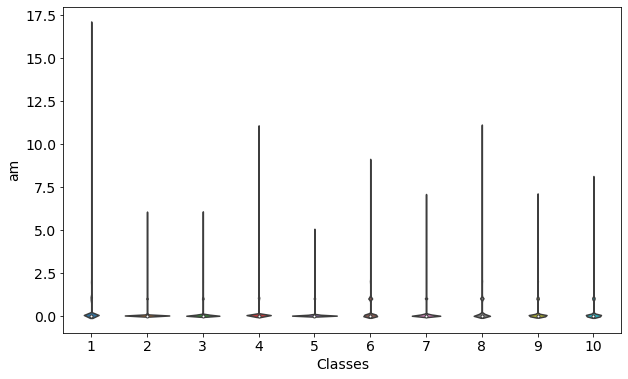

In [14]:
fig,axs = plt.subplots(figsize=(10,6));
axs = sns.violinplot(x='target',y='who', data=df , kind='swarm');
axs.set_xlabel('Classes');
axs.set_ylabel('am');
matplotlib.rcParams.update({'font.size': 14})

In [15]:
df.groupby('target')[['what','who','why','how','where']].mean().round(2)

,what,who,why,how,where
target,,,,,
1,0.49,0.18,0.26,0.24,0.09
2,0.45,0.04,0.13,0.31,0.07
3,0.45,0.06,0.10,0.31,0.05
4,0.47,0.08,0.08,0.25,0.08
5,0.31,0.04,0.07,0.49,0.11
6,0.29,0.24,0.10,0.19,0.08
7,0.40,0.09,0.08,0.32,0.10
8,0.41,0.22,0.09,0.21,0.11
9,0.54,0.16,0.16,0.38,0.06


In [16]:
target_classes_dict

{1: 'Society & Culture',
 2: 'Science & Mathematics',
 3: 'Health',
 4: 'Education & Reference',
 5: 'Computers & Internet',
 6: 'Sports',
 7: 'Business & Finance',
 8: 'Entertainment & Music',
 9: 'Family & Relationships',
 10: 'Politics & Government'}

In [17]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,am,is,are,why,can,do,does,where,who
924194,10,Hey republicans...Hillary Clinton won!!! How d...,Right now she just won 69% to 29% with the thi...,okay .....enough is enough. will you stop rubb...,Hey republicans...Hillary Clinton won!!! How d...,Hey republicans...Hillary Clinton won!!! How d...,0.000000,0.000,0,1,0,1,1,0,2,1,1,0,0
675938,6,where to sale basketball cards?,,How about EBay?,where to sale basketball cards?,where to sale basketball cards?How about EBay?,0.000000,0.000,0,0,0,0,0,0,0,0,0,1,0
1221483,9,my husband wont let me out of the house and i...,i try to tell him that i need to walk around a...,the fact that your husband is that controlling...,my husband wont let me out of the house and i...,my husband wont let me out of the house and i...,0.166667,0.250,1,0,2,0,0,0,3,2,0,0,0
92259,1,"Other than Roses , what other kinds of flowers...",,"tulips,daisies,birds of paradise,antherisms","Other than Roses , what other kinds of flowers...","Other than Roses , what other kinds of flowers...",-0.125000,0.375,1,0,0,0,0,0,0,0,0,0,0
207793,7,How can I work from home and get rich quickly?,,They are all scams. You cant get rich quick un...,How can I work from home and get rich quickly?,How can I work from home and get rich quickly?...,0.354167,0.625,0,1,0,0,0,0,1,0,0,0,0


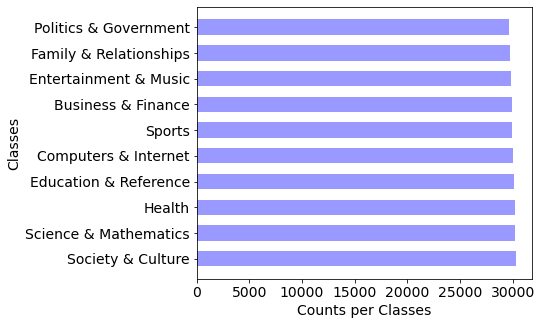

In [18]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [19]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [20]:
lst_stopwords = stopwords.words('english')+['else',"ya"]

In [21]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [22]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [23]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,am,is,are,why,can,do,does,where,who,Text_new
924194,10,Hey republicans...Hillary Clinton won!!! How d...,Right now she just won 69% to 29% with the thi...,okay .....enough is enough. will you stop rubb...,Hey republicans...Hillary Clinton won!!! How d...,Hey republicans...Hillary Clinton won!!! How d...,0.000000,0.000,0,1,0,1,1,0,2,1,1,0,0,hey republican hillary clinton make feel right...
675938,6,where to sale basketball cards?,,How about EBay?,where to sale basketball cards?,where to sale basketball cards?How about EBay?,0.000000,0.000,0,0,0,0,0,0,0,0,0,1,0,sale basketball card ebay
1221483,9,my husband wont let me out of the house and i...,i try to tell him that i need to walk around a...,the fact that your husband is that controlling...,my husband wont let me out of the house and i...,my husband wont let me out of the house and i...,0.166667,0.250,1,0,2,0,0,0,3,2,0,0,0,husband wont let house month pregnant get chan...
92259,1,"Other than Roses , what other kinds of flowers...",,"tulips,daisies,birds of paradise,antherisms","Other than Roses , what other kinds of flowers...","Other than Roses , what other kinds of flowers...",-0.125000,0.375,1,0,0,0,0,0,0,0,0,0,0,rose kind flower r given valentine day tulip d...
207793,7,How can I work from home and get rich quickly?,,They are all scams. You cant get rich quick un...,How can I work from home and get rich quickly?,How can I work from home and get rich quickly?...,0.354167,0.625,0,1,0,0,0,0,1,0,0,0,0,work home get rich quickly scam cant get rich ...


In [24]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [25]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,polarity,subjectivity,what,how,...,do,does,where,who,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
924194,10,Hey republicans...Hillary Clinton won!!! How d...,Right now she just won 69% to 29% with the thi...,okay .....enough is enough. will you stop rubb...,Hey republicans...Hillary Clinton won!!! How d...,Hey republicans...Hillary Clinton won!!! How d...,0.0,0.0,0,1,...,1,1,0,0,hey republican hillary clinton make feel right...,66,331,30,5.015152,2.2
675938,6,where to sale basketball cards?,,How about EBay?,where to sale basketball cards?,where to sale basketball cards?How about EBay?,0.0,0.0,0,0,...,0,0,1,0,sale basketball card ebay,7,40,1,5.714286,7.0


In [26]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

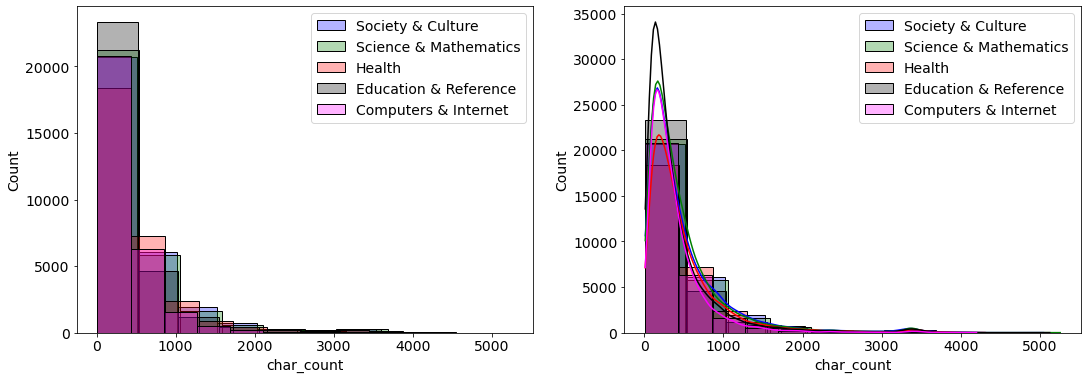

In [27]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [28]:
df.groupby('target').word_count.median()

target
1     70
2     66
3     76
4     52
5     59
6     45
7     54
8     41
9     74
10    73
Name: word_count, dtype: int64

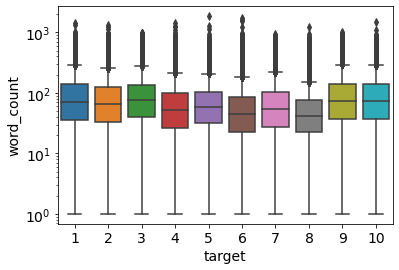

In [29]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

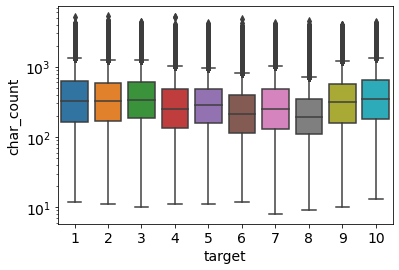

In [30]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

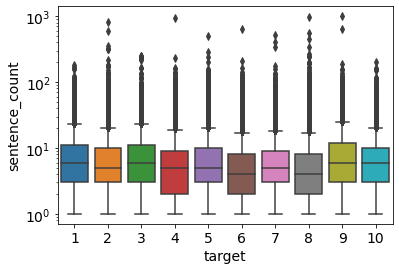

In [31]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

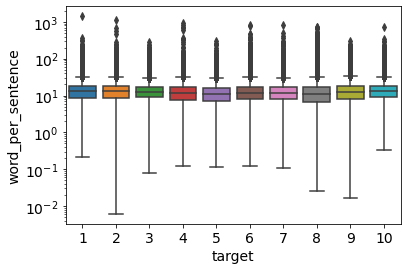

In [32]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [33]:
X = df.Text_new
y = df.target

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [35]:
vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

In [36]:
XX_train = vect.fit_transform(X_train)

In [37]:
XX_test = vect.transform(X_test)

In [38]:
vocab = vect.vocabulary_

In [39]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [40]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

9184

In [41]:
df_features.head(5)

,feature,Score,y
108,abraham,1.0,1
124,accent,1.0,1
125,accept,1.0,1
181,adam,1.0,1
182,adam eve,1.0,1


In [42]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 2878
abraham,accent,accept,adam,adam eve,agnostic,allah,almighty,amen,ancient,angel,apostle,arabic,atheist,baptism,baptist,baptized,being,belief,believe,believe god,believe jesus,believer,believing,bible,bible say,biblical,black,black people,bless

category 2: Science & Mathematics
length of category 2: 4115
100,2a,2x,2x 2x,2y,3x,3y,4x,4y,5x,6x,7x,8x,9x,absorbed,acceleration,acid,acidic,air,algebra,allele,altitude,aluminum,american,amino,amino acid,ammonia,amount,angle,angular

category 3: Health
length of category 3: 3871
ab,abdomen,abdominal,abnormal,ache,acne,active,acute,addiction,adhd,affect,aid,alcohol,allergic,allergic reaction,allergy,also,american,anal,anemia,ankle,antibiotic,antibody,anxiety,appetite,appointment,arm,artery,arthritis,ask doctor

category 4: Education & Reference
length of category 4: 2241
10th,abroad,academic,accredited,adjective,admission,algebra,ap,art,assignment,attend,author,bachelor,bachelor degree,biolo

In [43]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [44]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(270000, 9184)

In [45]:
XX_test = vect.transform(X_test)

In [46]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [47]:
# Creating a cloud of words

In [48]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [49]:
Text = " ".join(df_features[df_features.y==10].feature[:30])
Text

'11 abortion accused action administration afghanistan agency agenda agree air force al alien allowed ally amendment america american american citizen american flag american people amnesty appeal appointed approval arab armed armed force army arrest arrested'

In [50]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

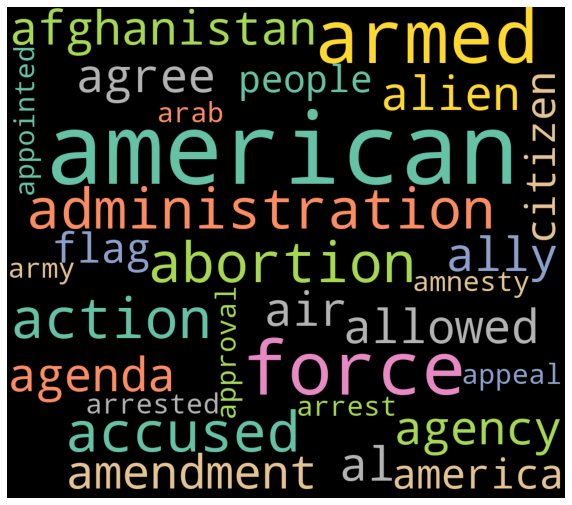

In [51]:
plot_cloud(wordcloud)

In [52]:
# cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [53]:
# X_train_cvec = cvec.fit_transform(X_train)
# X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [54]:
nb = naive_bayes.MultinomialNB()

In [55]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [56]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6756629629629629

In [57]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [58]:
## Test Classifier
Predicted_nb = nb.predict(XX_test)
Predicted_prob_nb = nb.predict_proba(XX_test)

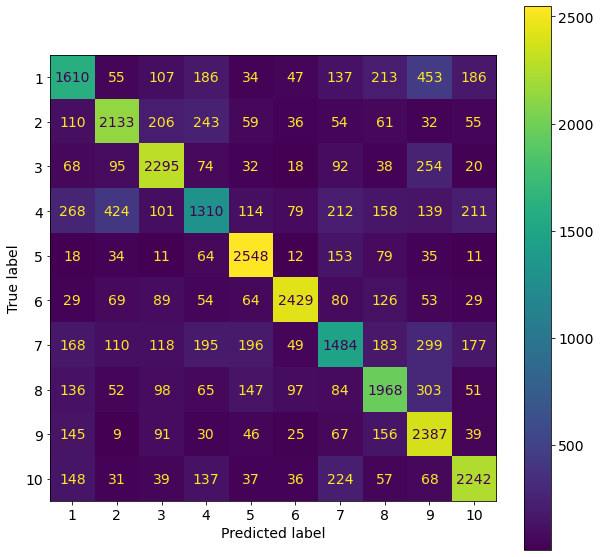

In [59]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

## Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [60]:
model_lr = LogisticRegression(max_iter=5000,n_jobs=-1)

In [61]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [62]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6913148148148147

In [63]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000, n_jobs=-1)

In [64]:
## Test Classifier
Predicted_lr = model_lr.predict(XX_test)
Predicted_prob_lr = model_lr.predict_proba(XX_test)

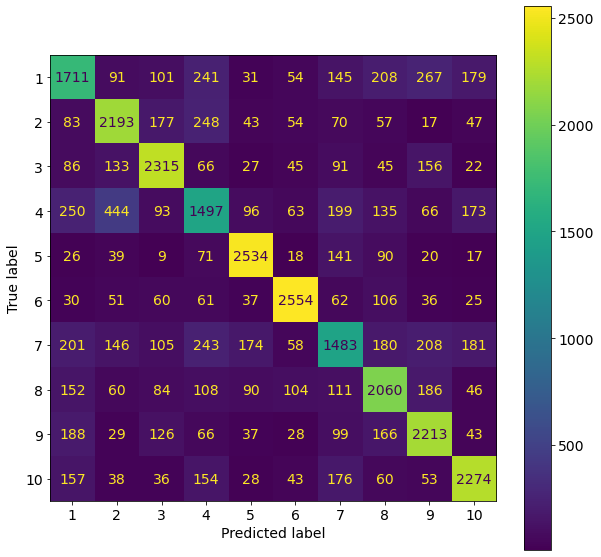

In [65]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

In [66]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted_lr)
auc = roc_auc_score(y_test,Predicted_prob_lr,multi_class='ovr')

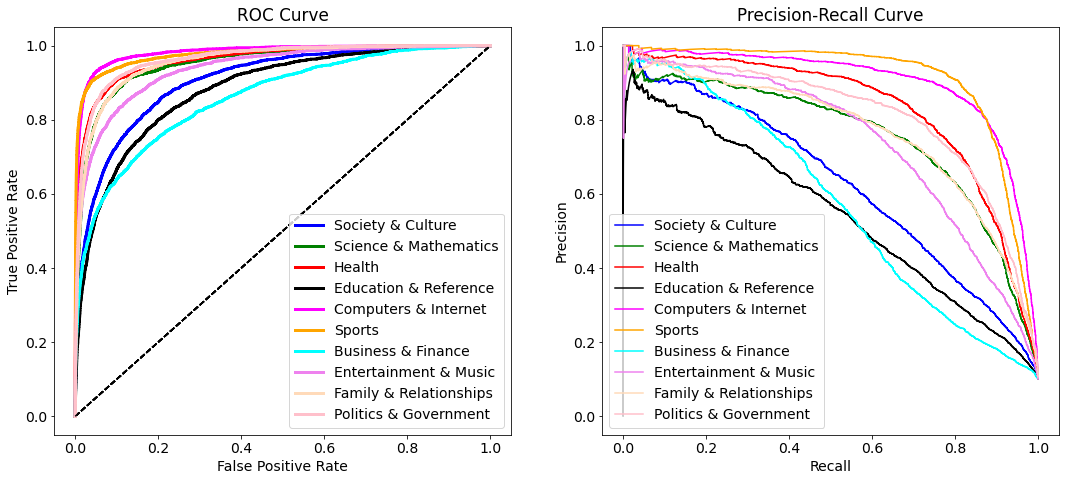

In [67]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob_lr[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob_lr[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()

In [68]:
def logreg_coef_importance(fit_logreg, tvectorizer):
    feature_names = tvectorizer.get_feature_names()
    coef_matrix = lr.coef_
    dict_list = []
    for coef_row in coef_matrix:
        print(coef_row)
        d = {}
        for coef, feature_name in zip(coef_row, feature_names):
            d[feature_name] = coef

        sorted_values = list(reversed(sorted(d.values()))) # Sort the values
        sorted_dict = {}
        for i in sorted_values:
            for k in d.keys():
                if d[k] == i:
                    sorted_dict[k] = d[k]
                    break
        dict_list.append(sorted_dict)

    return dict_list

In [69]:
feature_names = vect.get_feature_names()
coef_matrix = model_lr.coef_
dict_list=[]
for coef_row in coef_matrix:
    d={}
    for coef,fname in zip(coef_row,feature_names):
        d[fname] = coef
    sorted_values = list(reversed(sorted(d.values())))
    sorted_dict = {}
    for i in sorted_values:
        for k in d.keys():
            if d[k]==i:
                sorted_dict[k]=d[k]
                break
    dict_list.append(sorted_dict)




In [70]:
dict_list[9]

{'bush': 7.373026749139582,
 'liberal': 6.663363767705872,
 'republican': 6.197736155316583,
 'election': 6.140002268457315,
 'military': 6.118562407424588,
 'government': 6.106625992188375,
 'president': 6.05948403513382,
 'political': 5.648383588054136,
 'democrat': 5.643823197684891,
 'iraq': 5.226213394607183,
 'philipdru': 5.085958870254398,
 'illegals': 5.001097914011598,
 'army': 4.8877062842703465,
 'law': 4.840590437847224,
 'politics': 4.807712408948955,
 'immigration': 4.799614492915875,
 'legal': 4.722973882340309,
 'marine': 4.621070625403293,
 'politician': 4.585189761111258,
 'war': 4.396574088289999,
 'illegal': 4.298010060215229,
 'court': 4.283065128610797,
 'police': 4.276904269356807,
 'clinton': 4.179001810213339,
 'immigrant': 4.154800621965706,
 'congress': 4.076407831777975,
 'navy': 4.073628120531389,
 'visa': 4.062059167780044,
 'conservative': 4.061199582688116,
 'democracy': 4.009595707376013,
 'lawyer': 4.001608263583839,
 'goverment': 3.998178506110565,
 '

In [71]:
print(classification_report(y_test,Predicted_lr,target_names=target_classes))

                        precision    recall  f1-score   support

     Society & Culture       0.59      0.57      0.58      3028
 Science & Mathematics       0.68      0.73      0.71      2989
                Health       0.75      0.78      0.76      2986
 Education & Reference       0.54      0.50      0.52      3016
  Computers & Internet       0.82      0.85      0.84      2965
                Sports       0.85      0.85      0.85      3022
    Business & Finance       0.58      0.50      0.53      2979
 Entertainment & Music       0.66      0.69      0.67      3001
Family & Relationships       0.69      0.74      0.71      2995
 Politics & Government       0.76      0.75      0.75      3019

              accuracy                           0.69     30000
             macro avg       0.69      0.69      0.69     30000
          weighted avg       0.69      0.69      0.69     30000



## Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [72]:
model_rf = RandomForestClassifier(n_estimators=1000,max_features=20,max_depth=40,n_jobs=-1)

In [73]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [74]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6243814814814815

In [81]:
training_scores=[]
test_scores=[]
# for tree in tree_list:
model_rf = RandomForestClassifier(n_estimators=1000,max_features=50,max_depth=300,n_jobs=-1)
model_rf.fit(XX_train,y_train)
training_scores.append(accuracy_score(y_train,model_rf.predict(XX_train)))
test_scores.append(accuracy_score(y_test,model_rf.predict(XX_test)))   

In [82]:
training_scores

[0.9889222222222223]

In [83]:
test_scores

[0.6446]

In [84]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

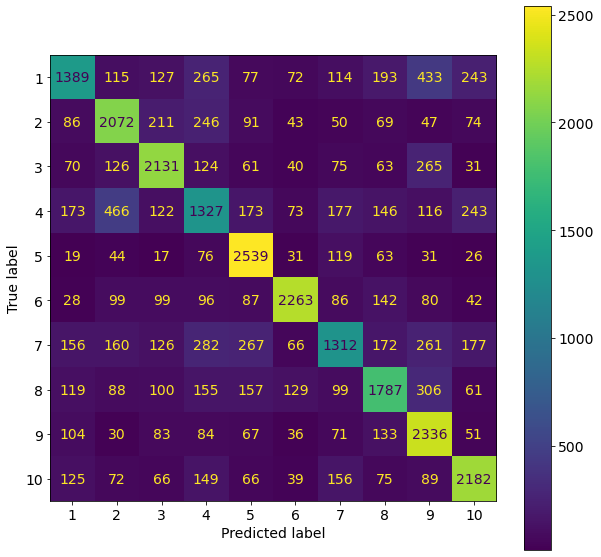

In [85]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

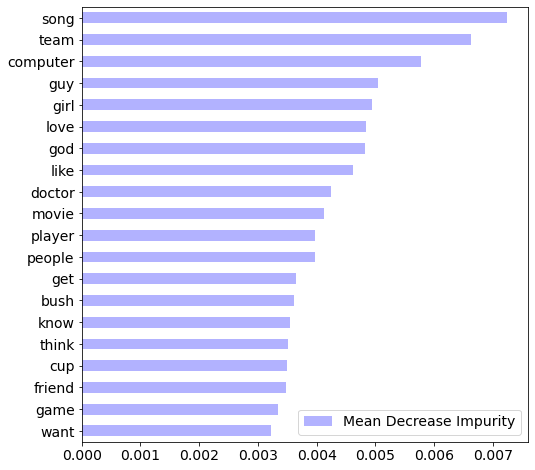

In [86]:
feature_names = list(X_names_unique)
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : model_rf.feature_importances_}, index=feature_names)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)[:20]
feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
ax = plt.gca().invert_yaxis()
leg = plt.legend( loc = 'lower right')

In [87]:
# results = permutation_importance(model_rf, XX_test.todense(), y_test, n_repeats=5, random_state=0)
# feature_scores = pd.DataFrame({'feature_importance_mean' : results.importances_mean}, index=feature_names)
# feature_scores = feature_scores.sort_values(by='feature_importance_mean', ascending=False)
# feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
# plt.gca().invert_yaxis()

### Binary Classification

In [88]:
y_train_binary = y_train.replace([1,2,3,4,6,7,8,9,10],0)

In [89]:
y_train_binary = y_train_binary.replace(5,1)

In [90]:
y_test_binary = y_test.replace([1,2,3,4,6,7,8,9,10],0)

In [91]:
y_test_binary = y_test_binary.replace(5,1)
y_test_binary.value_counts()

0    27035
1     2965
Name: target, dtype: int64

In [92]:
model_lr = LogisticRegression(max_iter=5000,class_weight='balanced')

In [93]:
cross_val_score(model_lr,XX_train,y_train_binary,cv=5,n_jobs=-1).mean()

0.9497148148148147

In [94]:
model_lr.fit(XX_train,y_train_binary)

LogisticRegression(class_weight='balanced', max_iter=5000)

In [95]:
## Test Classifier
Predicted = model_lr.predict(XX_test)
Predicted_prob = model_lr.predict_proba(XX_test)

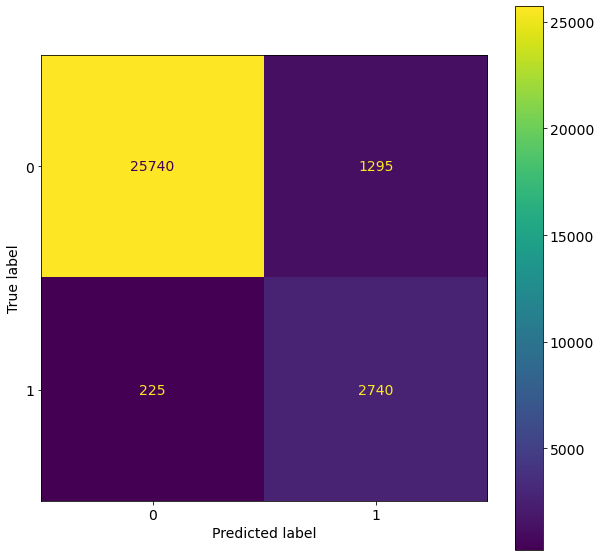

In [96]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test_binary,ax=ax);

### GridSearch CV

In [97]:
# opt_model = pipeline.Pipeline([
#            ('vectopt', TfidfVectorizer()),
#            ('classifier', model_lr)])

In [98]:
# parameters = {
#     'vectopt__max_df': (0.98, 1.0),
#     'vectopt__min_df': (0.01, 0.02 ),
#     'vectopt__max_features': (2000, 5000, 10000),
#     'vectopt__ngram_range': ((1, 1), (1, 2), (1,3))  
#                 }

In [99]:
# # lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=2,verbose=1,scoring='accuracy',n_jobs=-1)
# lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=5,verbose=1,n_jobs=50)

In [100]:
# lr_gs.fit(X_train,y_train)

In [101]:
# e = pd.DataFrame(lr_gs.cv_results_)

In [102]:
# e.sort_values(by='mean_test_score',axis=0,ascending=False)

### USE THE BELOW LINES FOR DEBUGGING

In [103]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [104]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

Int64Index([  71881,  250093,  131179,  196882,  948895,  816637,  228847,
            1137552,  145693,  975084,
            ...
            1259807,  614739, 1118605,  398211, 1271074,  181542, 1117585,
             202151,  569194,  973810],
           dtype='int64', length=2979)

In [105]:
X_test[(y_test!=Predicted) & (y_test==7)].index

Int64Index([  71881,  250093,  131179,  196882,  948895,  816637,  228847,
            1137552,  145693,  975084,
            ...
            1259807,  614739, 1118605,  398211, 1271074,  181542, 1117585,
             202151,  569194,  973810],
           dtype='int64', length=2979)

In [106]:
index_number = 43695

In [107]:
X_test.loc[index_number]

KeyError: 43695

In [ ]:
df.loc[index_number]

In [ ]:
df.loc[index_number]['Q&A']

In [ ]:
vocab

In [ ]:
test_set = 55
text = X_test.iloc[test_set]
text

In [ ]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

In [ ]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [ ]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=5,top_labels=1)

In [ ]:
explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
gg = model_lr.predict(XX_train)

In [ ]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train

In [ ]:
g = df[df.target==7]
g.head()

In [ ]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)

In [ ]:
text= 'This is ok '

In [ ]:
TextBlob(text).sentiment.polarity